In [32]:
import os
import re
import warnings
import datetime
import pickle
# обработка данных
import pandas as pd
import numpy as np
from itertools import product
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
# визуализация данных
import matplotlib.pyplot as plt
from tqdm import tqdm
# модели для обучения
from sklearn.ensemble import BaggingRegressor
# метрики точности моделей
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

warnings.filterwarnings("ignore")

# Предобработка данных

In [2]:
paths = os.listdir(path='F:\\')
bb_path = list(filter(lambda file: file.endswith('BB.csv'), paths))[0]
hh_path = list(filter(lambda file: file.endswith('HH.csv'), paths))[0]

In [3]:
use_cols = ('FLTDAT', 'FLTTIME', 'FLTNUM')
dates = ['FLTDAT']
dtypes = {'FLTNUM': 'int16'}
bb = pd.read_csv('F:\\' + bb_path, delimiter=';', dtype=dtypes, parse_dates=dates, usecols=use_cols)
bb = bb.dropna(how='any', axis=0)
bb.drop_duplicates(inplace=True)

In [4]:
use_cols = ('FLT_NUM', 'DD', 'SEG_CLASS_CODE', 'FCLCLD',
            'PASS_BK', 'SA', 'AU', 'PASS_DEP', 'NS', 'DTD')
dates = ['DD']
dtypes = {'FLT_NUM': 'int16', 'FCLCLD': 'int16', 'PASS_BK': 'int16','SA': 'int16',
          'AU': 'int16', 'PASS_DEP': 'int16', 'NS': 'int16', 'DTD': 'int16'}
hh = pd.read_csv('F:\\hh_for_profiles.csv', dtype=dtypes, parse_dates=dates, usecols=use_cols)
hh = hh[hh['FCLCLD'] == 0]
hh.drop_duplicates(inplace=True)

In [5]:
apr_days, may_days = [29, 30], [1, 6, 7, 8, 9]
dec_days, jan_days = [29, 30, 31], [1, 2, 3, 4, 5, 6, 7, 8]
april, may, december, january = 4, 5, 12, 1
origin = datetime.datetime(1970, 1, 1)
for scd in tqdm(hh['SEG_CLASS_CODE'].unique()):
    subset = hh[hh['SEG_CLASS_CODE'] == scd]
    subset = pd.merge(bb, subset, left_on=['FLTNUM', 'FLTDAT'], right_on=['FLT_NUM', 'DD'])
    subset.dropna(how='any', axis=0, inplace=True)
    subset.drop(columns=['DD', 'FLT_NUM'], inplace=True)
    subset.drop_duplicates(inplace=True)
    subset['FLTDAT'] = pd.to_datetime(subset['FLTDAT'])
    subset['FLTTIME'] = pd.to_datetime(subset['FLTTIME'])
    subset['fltHour'] = subset['FLTTIME'].dt.hour
    subset['fltMinute'] = subset['FLTTIME'].dt.minute
    subset['weekend'] = (subset['FLTDAT'].dt.dayofweek > 4).astype(int) # 1 - выходной / 0 - рабочий
    subset['dayOfWeek'] = subset['FLTDAT'].dt.dayofweek # дни недели
    subset['holidays'] = \
    ((subset['FLTDAT'].dt.day.isin(apr_days)) & (subset['FLTDAT'].dt.month == april)   | # весенние
    (subset['FLTDAT'].dt.day.isin(may_days)) & (subset['FLTDAT'].dt.month == may)      | # 9 мая
    (subset['FLTDAT'].dt.day.isin(dec_days)) & (subset['FLTDAT'].dt.month == december) |  # преднг дни
    (subset['FLTDAT'].dt.day.isin(jan_days)) & (subset['FLTDAT'].dt.month == january))    # новогодние
    subset['holidays'] = subset['holidays'].astype(int)
    subset['FLTDAT'] = (subset['FLTDAT'] - origin).dt.days
    subset.drop(columns=['FCLCLD', 'PASS_DEP', 'FLTTIME'], inplace=True)
    subset.drop_duplicates(inplace=True)
    concats = []
    pass_bk_mean = int(subset['PASS_BK'].value_counts().mean())
    for elem in subset['PASS_BK'].unique():
        sub = subset[subset['PASS_BK'] == elem]
        if elem > pass_bk_mean:
            concats.append(sub.sample(n=pass_bk_mean, random_state=25))
        else:
            concats.append(sub.sample(n=pass_bk_mean, random_state=25, replace=True))
    subset = pd.concat(concats)
    subset.to_csv(f'F:\\reg_prepared\\SVO-AER_2018-01-01--2019-12-31reg_{scd}.csv', index=False)
del apr_days, may_days, dec_days, jan_days, april, may, december, january, origin

100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [03:55<00:00, 10.70s/it]


# Подготовка данных

In [2]:
path = 'F:\\reg_prepared\\'
paths = os.listdir(path=path)
datasets = {file[-5:-6:-1]: pd.read_csv(path + file) for file in paths}
for dataset in datasets:
    data = datasets[dataset]
    data.drop(columns=['SEG_CLASS_CODE'], inplace=True)

In [30]:
def train(model: BaseEstimator, dataset: pd.DataFrame, scores: tuple) -> tuple:
    score_train = {}
    score_test = {}
    X, y = dataset.drop(columns=['PASS_BK']), dataset['PASS_BK']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=100)
    model = model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    for score in scores:
        score_train[str(score).split()[1]] = round(score(y_train, y_train_pred), 4)
        score_test[str(score).split()[1]] = round(score(y_test, y_test_pred), 4)
    return model, score_train, score_test

def train_models(model: BaseEstimator, datasets: pd.DataFrame, metrics: tuple) -> tuple:
    cycle = tqdm(datasets)
    models, train_scores, test_scores = [], [], []
    for dataset in cycle:
        cycle.set_description(f"Обучение на классе {dataset}")
        result_training = train(model, datasets[dataset], metrics)
        models.append(result_training[0])
        train_scores.append(result_training[1])
        test_scores.append(result_training[2])
    return models, train_scores, test_scores

def charts(model: BaseEstimator, classes: list, train_scores: list, test_scores: list) -> None:
    metrics = tuple(train_scores[0].keys()) # кортеж всех метрик
    plt.style.use("seaborn")
    for i in range(len(train_scores[0])):
        plt.figure(figsize=(16, 14), dpi=180)
        test_score = np.clip([score[metrics[i]] for score in test_scores], 0, 1)
        plt.bar(classes, np.clip([score[metrics[i]] for score in train_scores], 0, 1), width=.9,
                  label='train', alpha=.5, color='#78DBE2') # метрики для train
        plt.bar(classes, test_score, width=.8, label='test', alpha=.8, color='#2dd29f') # test
        title = re.match(r'\w+(?=\()', str(model))[0] + ' ' + metrics[i]
        plt.title(title, pad=50, fontsize=22, fontname="Times New Roman")
        for j in range(len(classes)):
            plt.text(j, test_score[j], test_scores[j][metrics[i]], ha='center')
        plt.ylabel('Метрика', fontweight='bold', fontsize=18, fontname="Times New Roman")
        plt.legend(fontsize=14, loc='upper left')
        plt.show()

In [6]:
metrics = (mean_absolute_error, r2_score)
# MAE - в среднем отклонение между реальным и предсказанным значениями (меньше - лучше)
# R2 - насколько данные соответсвуют модели (чем ближе к 1.0, тем лучше); > 80% идеал
model = BaggingRegressor(n_jobs=-1)

In [7]:
models, train_scores, test_scores = train_models(model, datasets, metrics)

Обучение на классе Z: 100%|████████████████████████████████████████████████████████████| 22/22 [04:03<00:00, 11.05s/it]


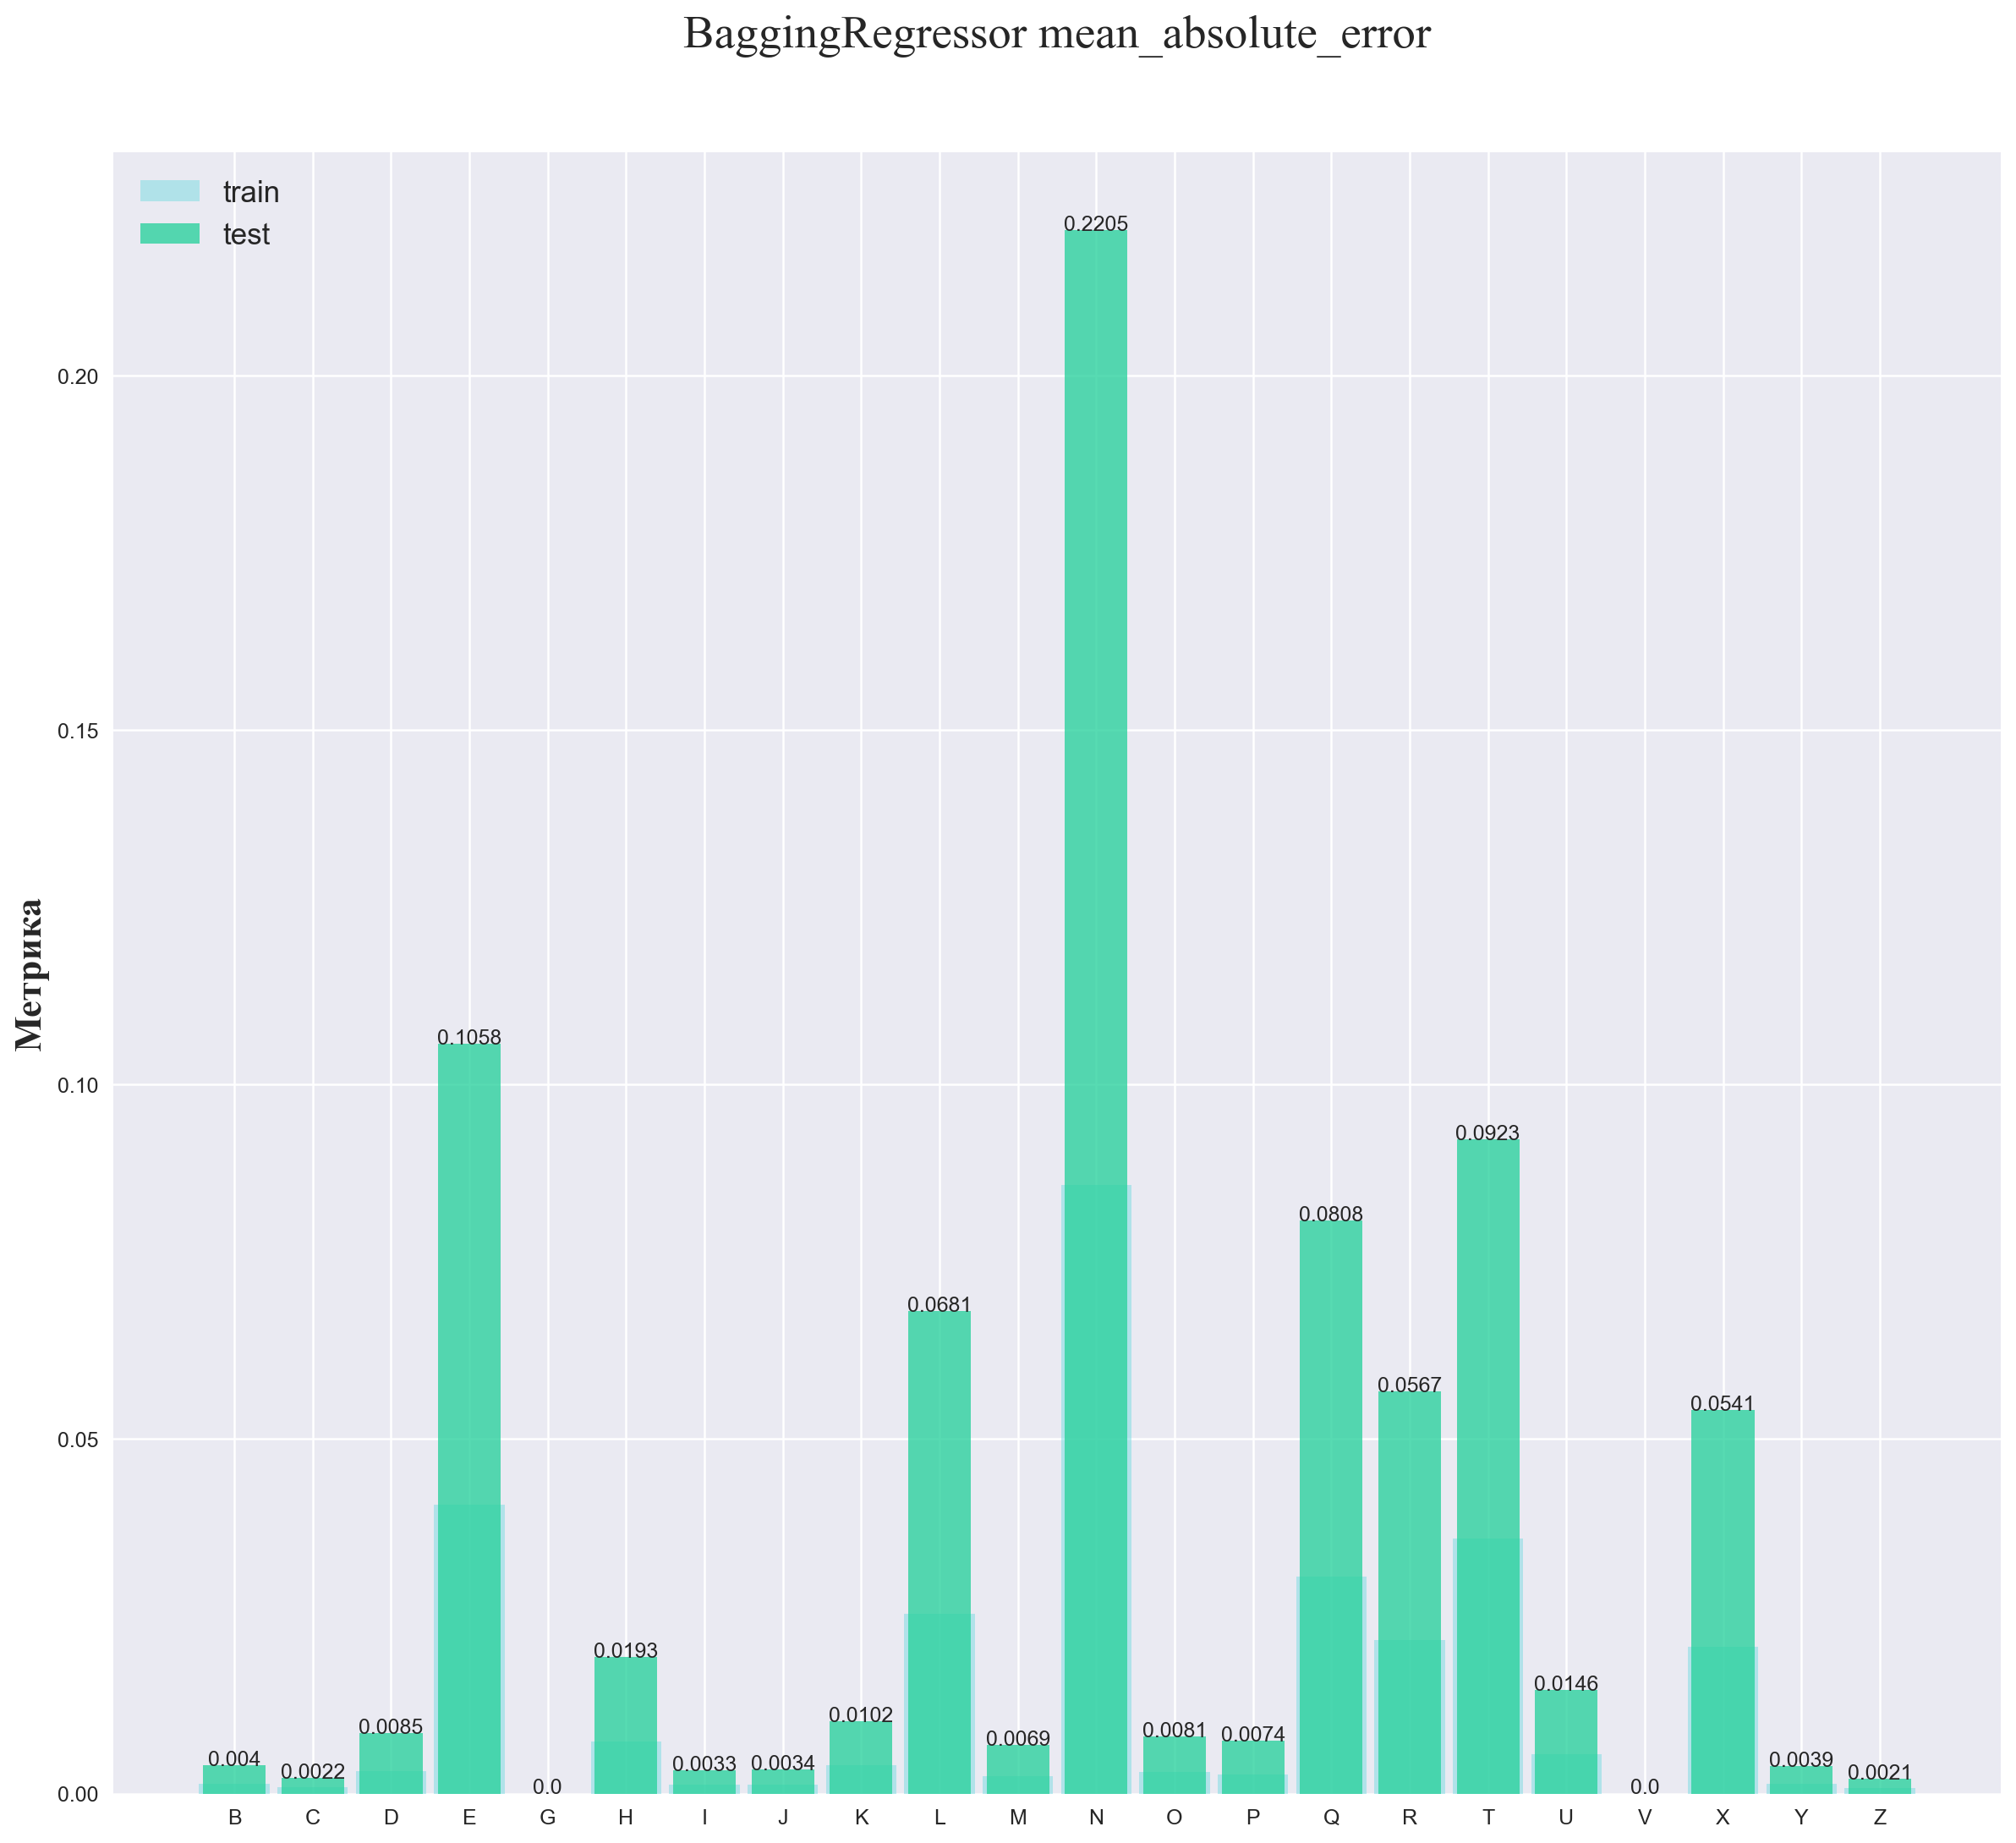

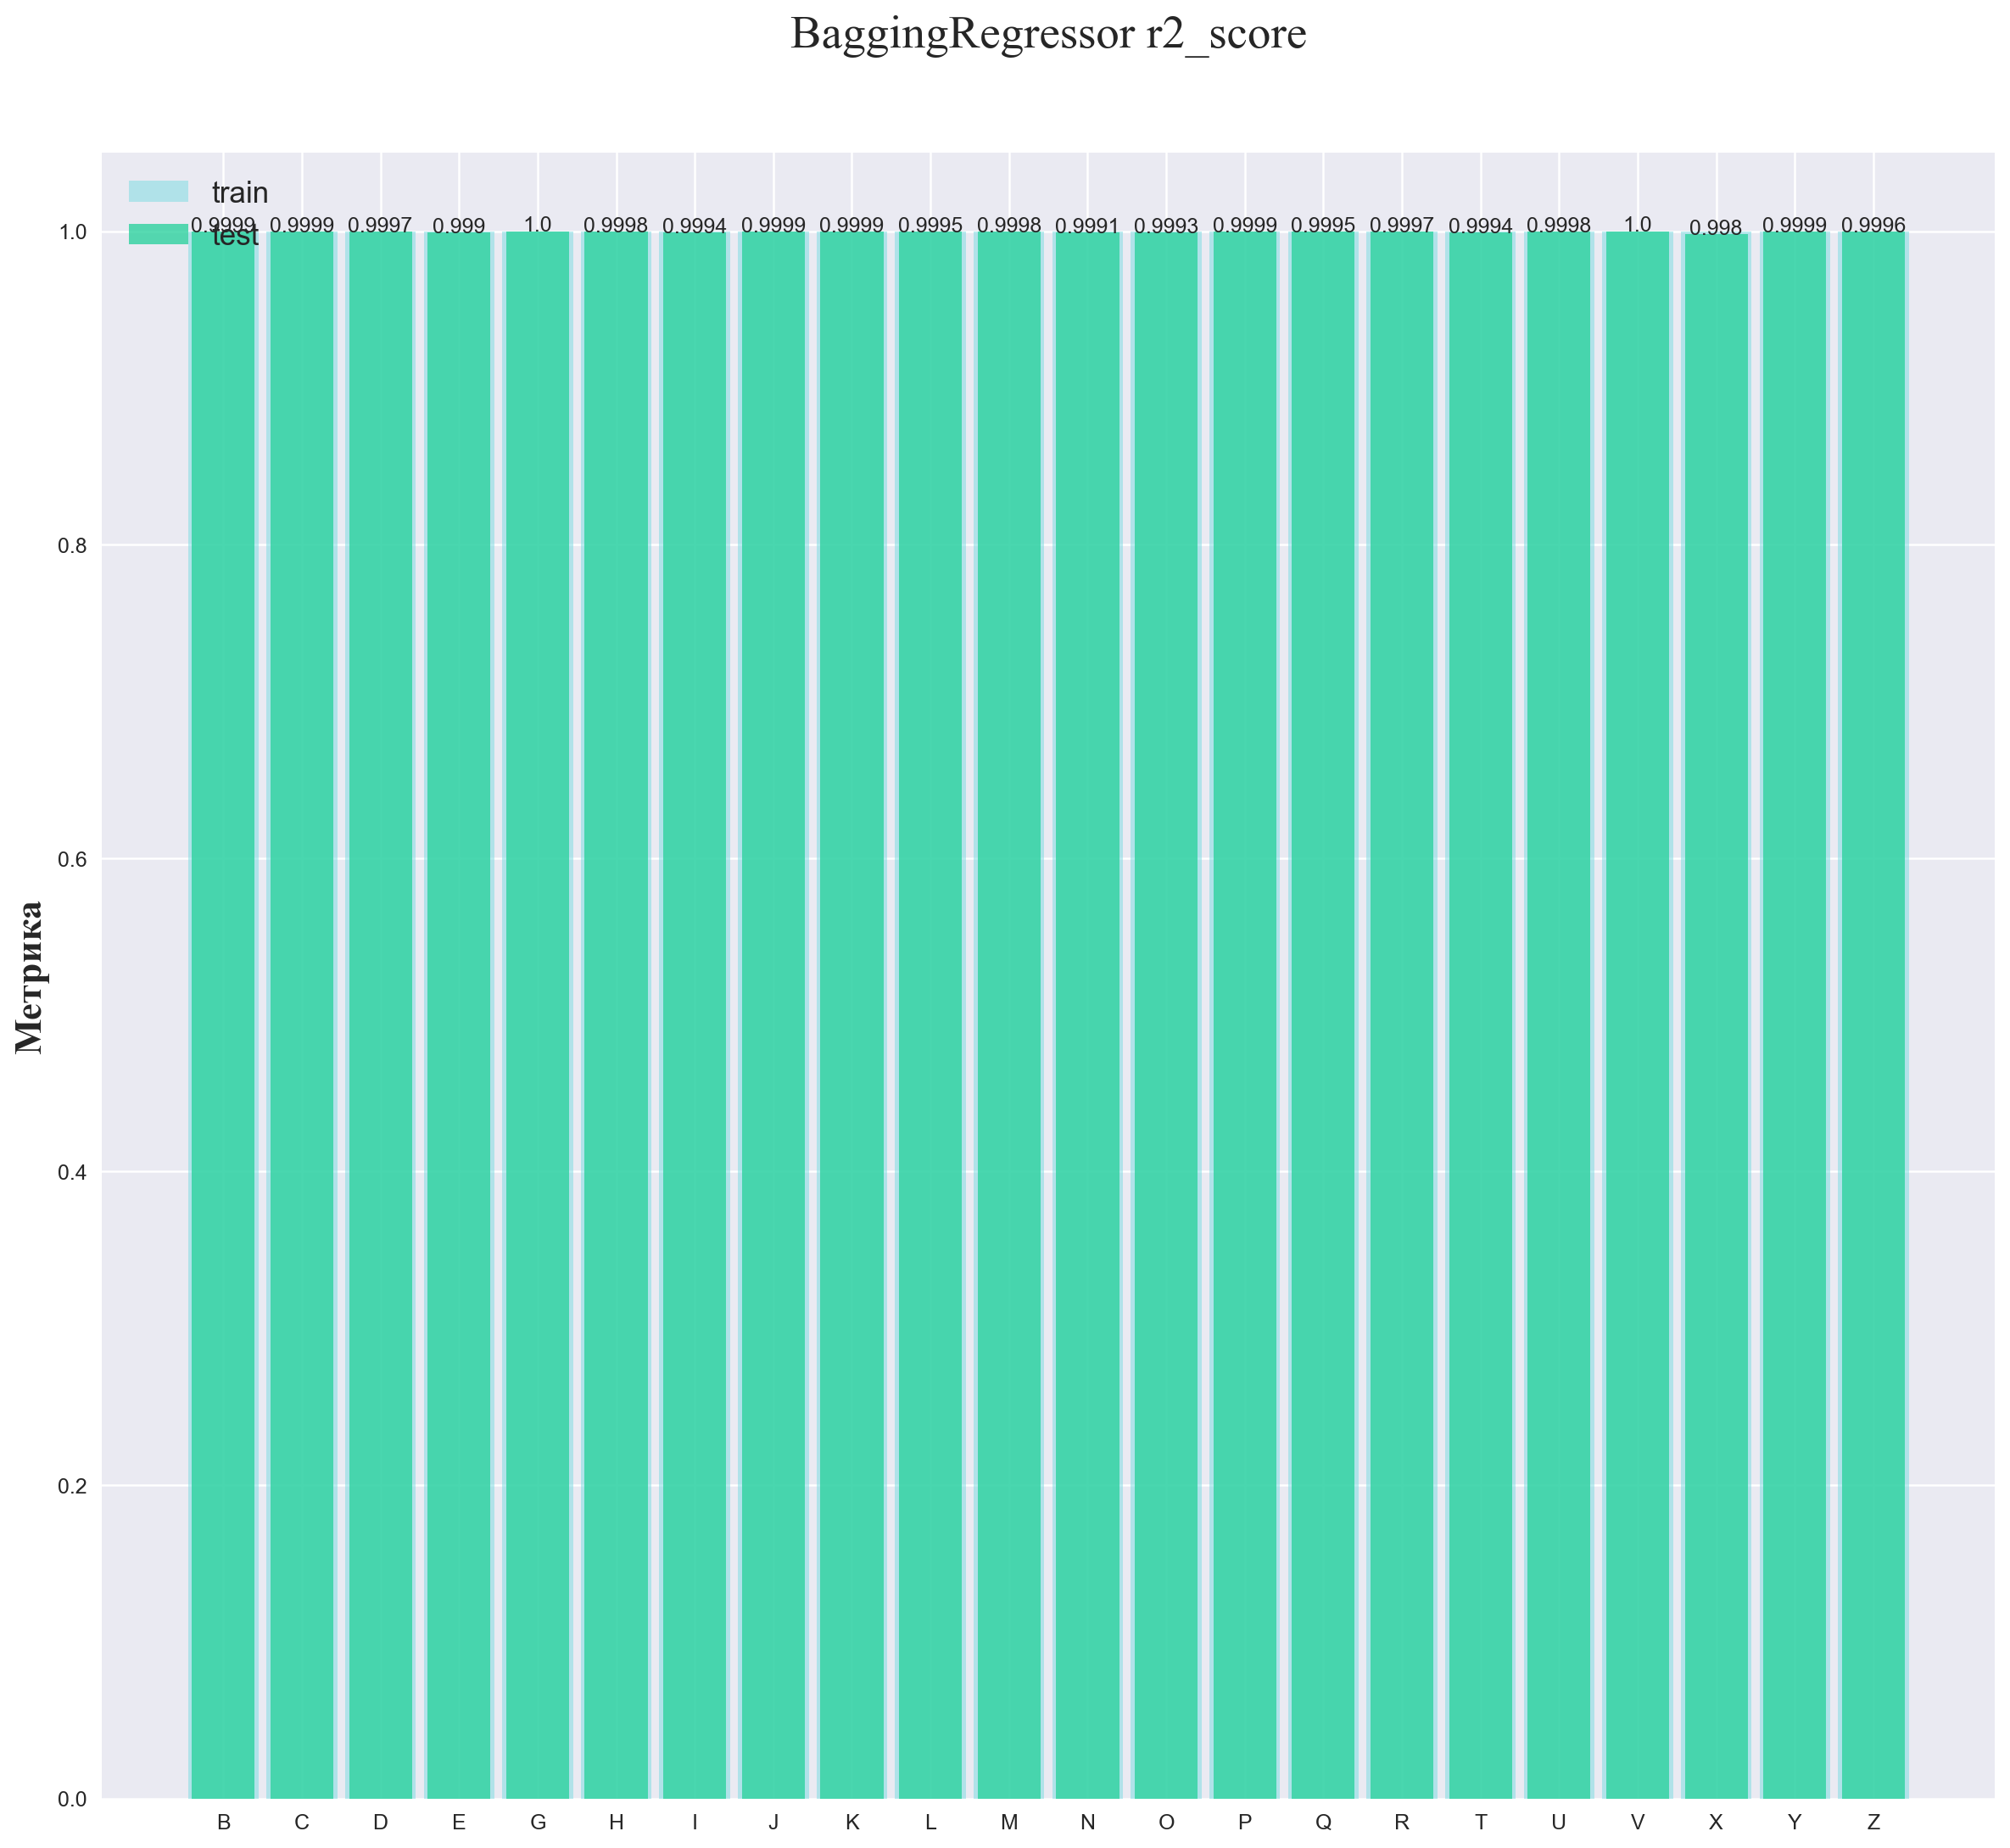

In [31]:
charts(model, datasets.keys(), train_scores, test_scores)

In [29]:
for model, scd in zip(models, datasets.keys()):
    file_name = 'F:\\models\\BaggingRegressor_'
    pickle_file = open(file_name + scd, 'wb') 
    pickle.dump(model, pickle_file)  
    pickle_file.close()